In [1]:
import os
from itertools import product

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_ttests
import pingouin as pg
from statsmodels.regression.mixed_linear_model import MixedLM

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u

import sklearn
from sklearn.mixture import BayesianGaussianMixture as BGM

plt.rcParams['pdf.fonttype']=42
ko_mice = stx.ymaze_sess_deets.ko_mice

ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
# ctrl_mice = [m for m in ctrl_mice if m not in ('mCherry6')]

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
figdir = "/mnt/BigDisk/YMazeResults/neural/field_shifts"
os.makedirs(figdir,exist_ok=True)

In [3]:
def crosscorr_mat(trial_mat, inds = np.arange(-29,29)):
    inds = np.arange(-29,30)
    cc_mat = np.nan*np.zeros([trial_mat.shape[0], trial_mat.shape[0], inds.shape[0]])
    for cell in range(trial_mat.shape[-1]):
        for trial0 in range(trial_mat.shape[0]):
            for trial1 in range(trial_mat.shape[0]):
                tmp = np.correlate(trial_mat[trial0,:,cell],trial_mat[trial1,:,cell],mode='full')
#                 if np.amax(tmp)>.2:
                cc_mat[trial0,trial1,:] += tmp
    
    return cc_mat/trial_mat.shape[-1], inds

def pv_crosscorr(trial_mat):
    
    tm_z = sp.stats.zscore(trial_mat, axis=-1)

    n_trials, n_pos, n_cells = trial_mat.shape[0], trial_mat.shape[1], trial_mat.shape[-1]  
    cc_mat = np.zeros((n_trials, n_trials, 2*n_pos-1))
    for t,tp in product(range(n_trials), range(n_trials)):

        _z_t, _z_tp = tm_z[t,:,:], tm_z[tp,:,:]
        z_t, z_tp = np.zeros((n_pos*3-2,n_cells)), _z_tp[:,:]
        z_t[n_pos-1:2*n_pos-1,:] = _z_t
        for shift in range(0, 2*n_pos-1):
            cc_mat[t,tp,shift] = np.nanmean(np.nanmean(z_tp*z_t[shift:shift+n_pos,:], axis=-1), axis=0)

    return cc_mat

# def crosscorr_res(sess):
#     trial_mat = sp.ndimage.filters.gaussian_filter1d(sess.trial_matrices['spks_norm'][:,:,:],1,axis=1)
#     trial_mat[np.isnan(trial_mat)]=1E-5
    
#     cc_mat = pv_crosscorr(trial_mat)
    
#     return {'cc_mat': cc_mat,
#             'trial_info': sess.trial_info,
#             'speed': np.nanmean(sess.trial_matrices['speed'], axis=1)
#            }    

def cc_com(cc_mat, inds = np.arange(-29,30)):
    return np.nansum(cc_mat*inds[np.newaxis,np.newaxis,:], axis=-1)/(np.nansum(cc_mat,axis=-1)+1E-3)

shift = lambda com: com*(np.tril(-1*np.ones(com.shape),k=-1) + np.triu(np.ones(com.shape), k=1))

def run_crosscorr(sess, nov=True, max_trial = 5, arm_only = False, smooth = 0):
    if nov:
        trial_mask = sess.trial_info['LR']==sess.novel_arm
    else:
        trial_mask = (-1*sess.trial_info['LR']==sess.novel_arm) & (sess.trial_info['block_number']==5)
                  
    com = np.nan*np.zeros([max_trial,max_trial])
    if arm_only:
        trial_mat = sess.trial_matrices['spks_norm'][trial_mask,:,:][:max_trial,12:,:]
    else:
        trial_mat = sess.trial_matrices['spks_norm'][trial_mask,:,:][:max_trial,:,:]
        
    trial_mat[np.isnan(trial_mat)]=1E-3
        
    if smooth>0:
        if arm_only:
            trial_mat = sp.ndimage.filters.gaussian_filter1d(trial_mat, smooth, axis=1)[:max_trial,12:,:]
        else:
            trial_mat = sp.ndimage.filters.gaussian_filter1d(trial_mat, smooth, axis=1)[:max_trial,:,:]
        
    
    speed = np.nanmean(sess.trial_matrices['speed'][trial_mask,:,][:max_trial,:])
    cc_mat = pv_crosscorr(trial_mat)
    
    
    
    com[:trial_mat.shape[0], :trial_mat.shape[0]] = cc_com(cc_mat, inds = np.arange(-trial_mat.shape[1]+1,trial_mat.shape[1]))
    return {'cc_mat': cc_mat,
           'com': com,
           'shift': np.nanmean(shift(com)),
           'speed': speed}

In [4]:
loop_crosscorr = u.loop_func_over_days(run_crosscorr, np.arange(6), max_trial = 5, smooth=0.5, nov=True)

ko_res = {mouse:loop_crosscorr(mouse) for mouse in ko_mice}
ctrl_res = {mouse:loop_crosscorr(mouse) for mouse in ctrl_mice}

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:97: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/tmp/ipykernel_4019365/2491999530.py:63: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  trial_mat = sp.ndimage.filters.gaussian_filter1d(trial_mat, smooth, axis=1)[:max_trial,:,:]


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'ses

/tmp/ipykernel_4019365/2491999530.py:63: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  trial_mat = sp.ndimage.filters.gaussian_filter1d(trial_mat, smooth, axis=1)[:max_trial,:,:]


{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
({'date': '30_11_2020', 'scene': 'YMaze_LNovel',

/tmp/ipykernel_4019365/2491999530.py:63: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  trial_mat = sp.ndimage.filters.gaussian_filter1d(trial_mat, smooth, axis=1)[:max_trial,:,:]


{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 7}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '05_12_2020', 'scene': 'YMaze_LNovel', 's

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:97: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'ses

In [5]:
mouse = ctrl_mice[0]
x = np.arange(-290,300, 10)
# cc = ctrl_res[mouse][0]['cc_mat']

ctrl_cc = 0
for m, res in ctrl_res.items():
    ctrl_cc+=res[0]['cc_mat']
ctrl_cc/=len(ctrl_res)

ko_cc = 0
for m, res in ko_res.items():
    ko_cc+=res[0]['cc_mat']
ko_cc/=len(ko_res)

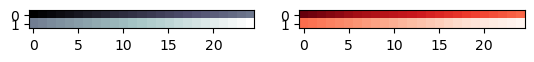

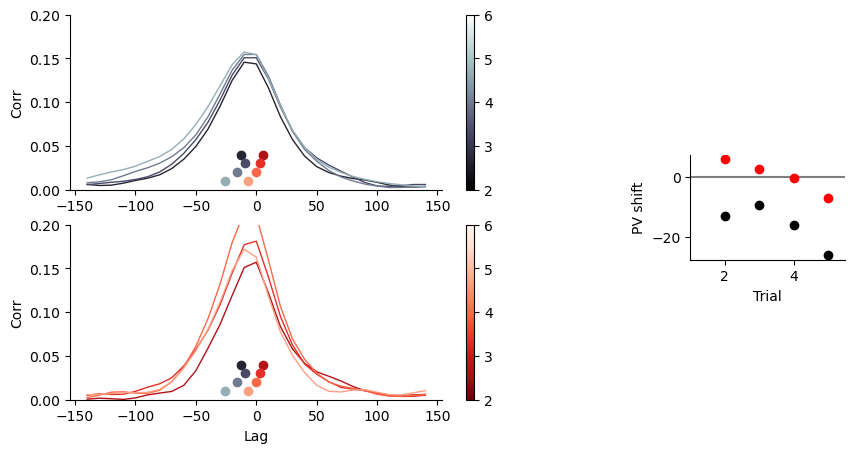

In [6]:
# print(cc.shape)
# fig,ax = plt.subplots()
a = np.linspace(2,6).reshape([2,25])
_fig,_ax = plt.subplots(1,2)
h_bone = _ax[0].imshow(a,cmap='bone')
h_reds = _ax[1].imshow(a,cmap='Reds_r')

fig = plt.figure(figsize = [10,5])
gs = fig.add_gridspec(6, 3)
ax_ctrl = fig.add_subplot(gs[:3, :2])
ax_ko = fig.add_subplot(gs[3:,:2])
ax1 = fig.add_subplot(gs[2:4,2:])
fig.subplots_adjust(hspace=1, wspace=1)

lw = 1
mask = np.abs(x)<150
for i in range(1,5):
    ax_ctrl.plot(x[mask],ctrl_cc[0,i,::-1][mask],color=plt.cm.bone(float(i)/6), linewidth=lw)
    ctrl_com = (x[::-1]*ctrl_cc[0,i,:]).sum()/ctrl_cc[0,i,:].sum()
    ax_ctrl.scatter(ctrl_com ,(5-i)/100,color=plt.cm.bone(float(i)/6))
    ax1.scatter(i+1, ctrl_com,color='black') #plt.cm.bone(np.float(i)/5))
    
    ax_ko.plot(x[mask],ko_cc[0,i,::-1][mask],color=plt.cm.Reds(float(6-i)/6), linewidth = lw)
    ko_com = (x[::-1]*ko_cc[0,i,:]).sum()/ko_cc[0,i,:].sum()
    ax_ko.scatter(ko_com ,(5-i)/100,color=plt.cm.Reds(float(6-i)/6))
    ax_ctrl.scatter(ko_com ,(5-i)/100,color=plt.cm.Reds(float(6-i)/6))
    ax_ko.scatter(ctrl_com ,(5-i)/100,color=plt.cm.bone(float(i)/6))
    ax1.scatter(i+1,ko_com, color='red') #plt.cm.Reds(np.float(5-i)/5))
    
ax1.set_xlim([1,5.5])
ax1.axhline(0, color='black',zorder = 0, alpha = .5)
# ax1.set_yticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
# ax1.spines['left'].set_visible(False)
ax1.set_ylabel('PV shift')
ax1.set_xlabel('Trial')

ax_ctrl.set_ylim([0,.2])
ax_ctrl.set_ylabel('Corr')
ax_ctrl.spines['top'].set_visible(False)
ax_ctrl.spines['right'].set_visible(False)
plt.colorbar(h_bone,ax=ax_ctrl)

ax_ko.set_ylim([0,.2])
ax_ko.set_ylabel('Corr')
ax_ko.spines['top'].set_visible(False)
ax_ko.spines['right'].set_visible(False)
ax_ko.set_xlabel('Lag')
plt.colorbar(h_reds,ax=ax_ko)

# fig.savefig(os.path.join(figdir, "trial1_crosscorr_allmice.pdf"))

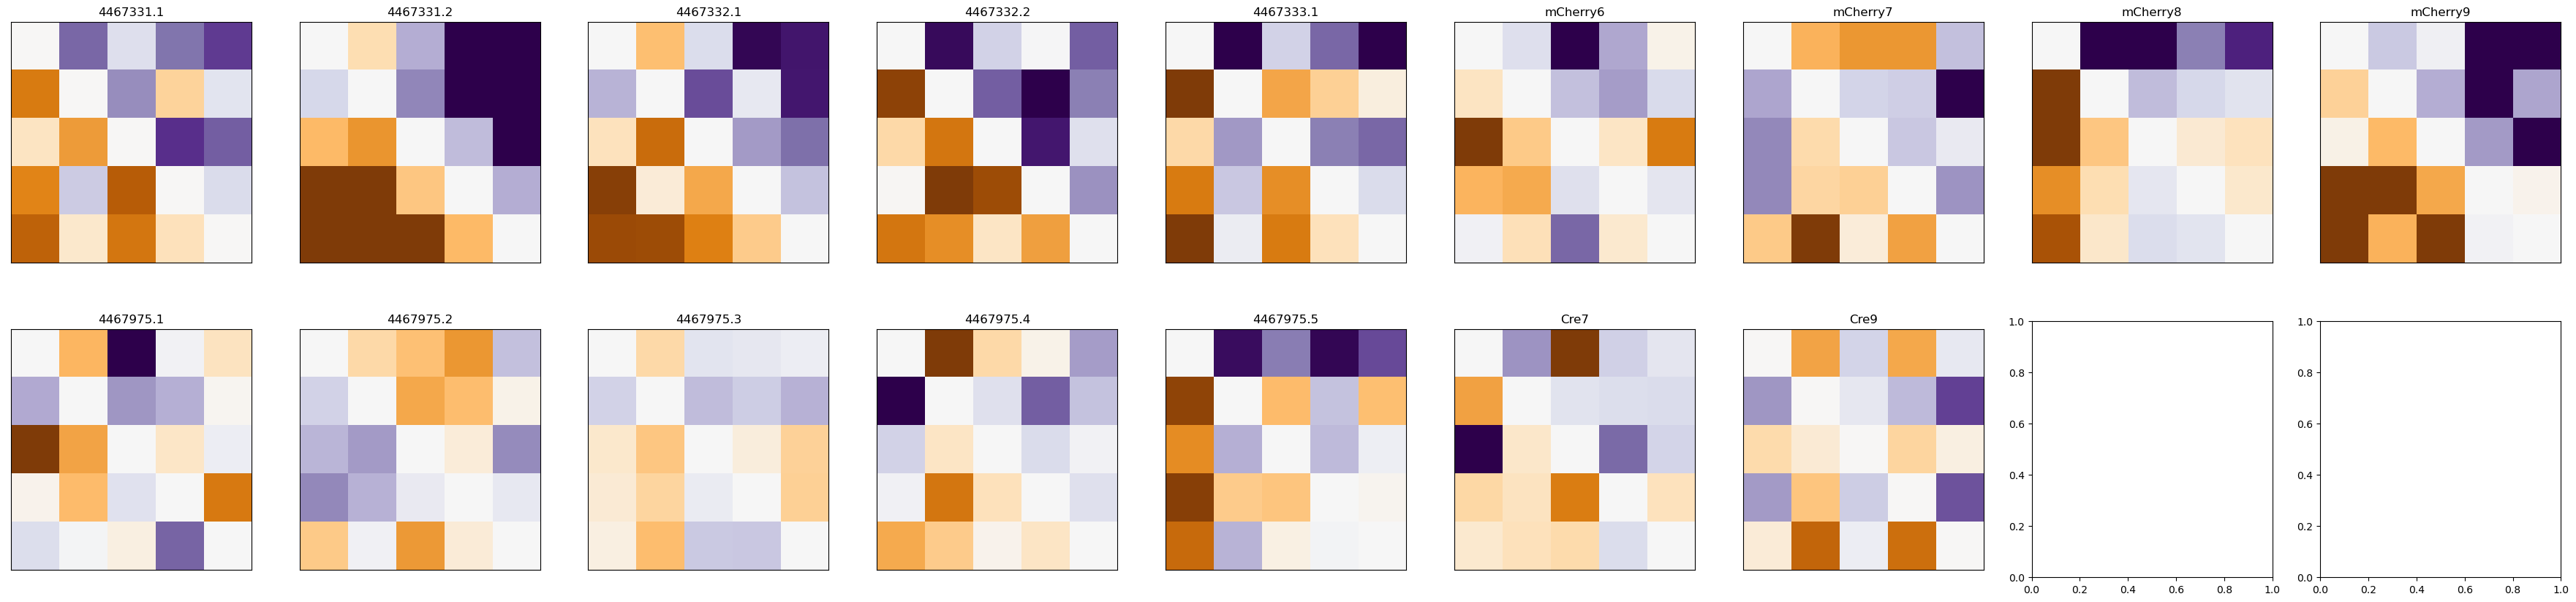

In [7]:
fig, ax = plt.subplots(2,len(ctrl_mice), figsize=[5*len(ctrl_mice), 10])

day = 0

for j, (m, res) in enumerate(ctrl_res.items()):
    
    ax[0,j].imshow(res[day]['com'], vmin = -3, vmax=3, cmap = 'PuOr')
    ax[0,j].set_title(m)
    ax[0,j].set_xticks([])
    ax[0,j].set_yticks([])




for j, (m, res) in enumerate(ko_res.items()):
    ax[1,j].imshow(res[day]['com'], vmin = -3, vmax=3, cmap = 'PuOr')
    ax[1,j].set_title(m)
    ax[1,j].set_xticks([])
    ax[1,j].set_yticks([])


# fig.savefig(os.path.join(figdir, "allmice_COM_mats.pdf"))

Text(0.5, 1.0, 'Cre')

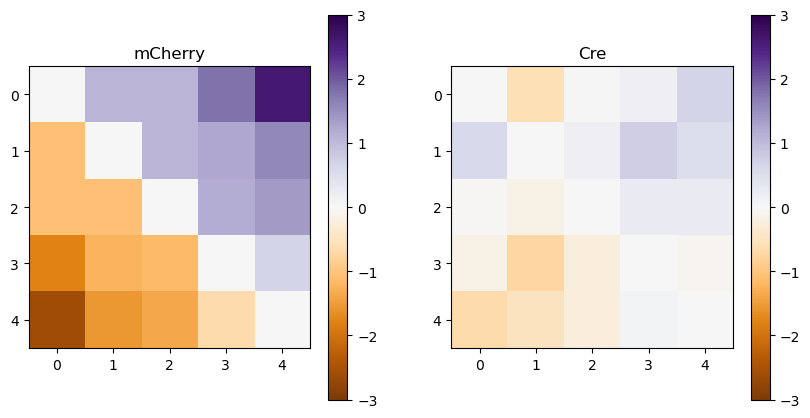

In [8]:
fig, ax = plt.subplots(1,2, figsize = [10,5])

day = 0
ctrl_cc_com = np.array([res[day]['com'] for m,res in ctrl_res.items()])
h = ax[0].imshow(np.nanmean(ctrl_cc_com,axis=0), vmin=-3, vmax=3, cmap='PuOr')
plt.colorbar(h,ax=ax[0])

ko_cc_com = np.array([res[day]['com'] for m,res in ko_res.items()])
h = ax[1].imshow(np.nanmean(ko_cc_com,axis=0), vmin=-3, vmax=3, cmap='PuOr')
plt.colorbar(h,ax=ax[1])

ax[0].set_title('mCherry')
ax[1].set_title('Cre')

# fig.savefig(os.path.join(figdir, "PV_COM_mats.pdf"))

-1.0873598182855302
-0.16284794894053106
day: 0, t=-4.394564, p=0.000611
day: 0, t=-6.729180, p=0.000148
day: 0, t=-1.410627, p=0.208036


Text(0.5, 0, 'Day')

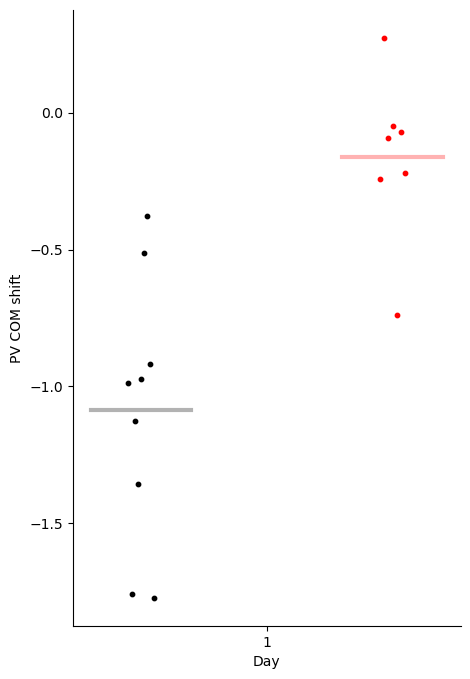

In [9]:
fig, ax = plt.subplots(figsize=[5,8])
for day in range(1):
    ctrl_shift = np.array([-1*res[day]['shift'] for m,res in ctrl_res.items()])
    print(ctrl_shift.mean())
    ax.scatter(5*day-.5 + np.linspace(-0.05,0.05, num=len(ctrl_mice)), ctrl_shift, s=10, color='black', alpha = 1)
    ax.plot(5*day -.5 + np.array([-.2,.2]), ctrl_shift.mean()*np.ones([2,]), color='black', alpha = .3, linewidth=3)
    
    ko_shift = np.array([-1*res[day]['shift'] for m,res in ko_res.items()])
    ax.scatter(5*day+.5 + np.linspace(-0.05,0.05, num=len(ko_mice)), ko_shift, s=10, color='red', alpha = 1)
    ax.plot(5*day + .5 + np.array([-.2,.2]), ko_shift.mean()*np.ones([2,]), color='red', alpha = .3, linewidth=3)
    print(ko_shift.mean())
    
    t,p = sp.stats.ttest_ind(ctrl_shift,ko_shift,nan_policy='omit')
#     t,p = sp.stats.ranksums(ctrl_shift,ko_shift)
    print("day: %d, t=%f, p=%f" % (day, t, p))
    
    t_c, p_c = sp.stats.ttest_1samp(ctrl_shift,0)
    print("day: %d, t=%f, p=%f" % (day, t_c, p_c))
    
    t_k, p_k = sp.stats.ttest_1samp(ko_shift,0)
    print("day: %d, t=%f, p=%f" % (day, t_k, p_k))
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(0,1*5,5))
ax.set_xticklabels([x for x in range(1,2)])
ax.set_ylabel('PV COM shift')
ax.set_xlabel('Day')

# fig.savefig(os.path.join(figdir, "PV_shift_summary_short.pdf"))

-1.0873598182855302
-0.16284794894053106
day: 0, t=-4.394564, p=0.000611
day: 0, t=-6.729180, p=0.000148
day: 0, t=-1.410627, p=0.208036
-0.12839721709802815
-0.1101461157691087
day: 1, t=-0.074552, p=0.941626
day: 1, t=-0.665819, p=0.524257
day: 1, t=-0.902011, p=0.401808
-0.17137689714528356
-0.24179044182915194
day: 2, t=0.615868, p=0.547864
day: 2, t=-3.585646, p=0.007129
day: 2, t=-2.101278, p=0.080336
-0.16659492346133073
-0.10178270898268456
day: 3, t=-0.293840, p=0.773191
day: 3, t=-0.940639, p=0.374421
day: 3, t=-1.013691, p=0.349849
-0.07236244706695776
0.17033927792056294
day: 4, t=-0.841319, p=0.414309
day: 4, t=-0.348624, p=0.736369
day: 4, t=0.905756, p=0.399974


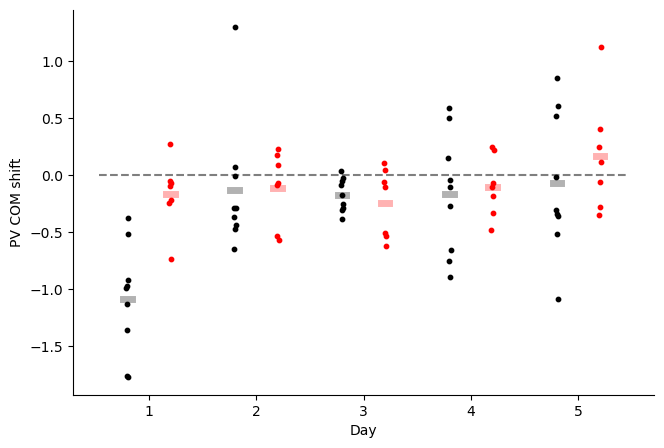

In [10]:
fig, ax = plt.subplots(figsize=[7.5,5])

s=10
lw = 5
for day in range(5):
    ctrl_shift = np.array([-1*res[day]['shift'] for m,res in ctrl_res.items()])
    print(ctrl_shift.mean())
    ax.scatter(5*day-1 + np.linspace(-0.05,0.05, num=len(ctrl_mice)), ctrl_shift, s=s, color='black', alpha = 1)
    ax.plot(5*day -1 + np.array([-.2,.2]), ctrl_shift.mean()*np.ones([2,]), color='black', alpha = .3, linewidth=lw)
    
    ko_shift = np.array([-1*res[day]['shift'] for m,res in ko_res.items()])
    ax.scatter(5*day+1 + np.linspace(-0.05,0.05, num=len(ko_mice)), ko_shift, s=s, color='red', alpha = 1)
    ax.plot(5*day + 1 + np.array([-.2,.2]), ko_shift.mean()*np.ones([2,]), color='red', alpha = .3, linewidth=lw)
    print(ko_shift.mean())
    
    t,p = sp.stats.ttest_ind(ctrl_shift,ko_shift,nan_policy='omit')
#     t,p = sp.stats.ranksums(ctrl_shift,ko_shift)
    print("day: %d, t=%f, p=%f" % (day, t, p))
    
    t_c, p_c = sp.stats.ttest_1samp(ctrl_shift,0)
    # t_c, p_c = sp.stats.wilcoxon(ctrl_shift)
    print("day: %d, t=%f, p=%f" % (day, t_c, p_c))
    
    t_k, p_k = sp.stats.ttest_1samp(ko_shift,0)
    # t_k, p_k = sp.stats.wilcoxon(ko_shift)
    print("day: %d, t=%f, p=%f" % (day, t_k, p_k))
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(0,5*5,5))
ax.set_xticklabels([x for x in range(1,6)])
ax.set_ylabel('PV COM shift')
ax.set_xlabel('Day')
ax.plot([-2.3, 22.3], np.zeros((2,)), 'k--', zorder= -1, alpha=.5)
fig.savefig(os.path.join(figdir, "PV_shift_summary.pdf"))

-0.3096030448783479 0.2432478424408301
0.25 0.5164895523012263
0.21428571428571433 0.6445115810207203


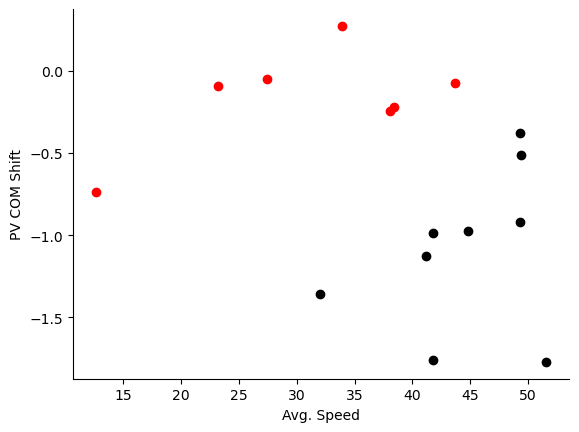

In [11]:
day = 0
ctrl_shift = np.array([-1*res[day]['shift'] for m,res in ctrl_res.items()])
ctrl_speed = np.array([res[day]['speed'] for m,res in ctrl_res.items()])

ko_shift = np.array([-1*res[day]['shift'] for m,res in ko_res.items()])
ko_speed = np.array([res[day]['speed'] for m,res in ko_res.items()])


fig, ax = plt.subplots()
ax.scatter(ctrl_speed, ctrl_shift, color='black')
ax.scatter(ko_speed, ko_shift, color='red')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Avg. Speed')
ax.set_ylabel('PV COM Shift')

r,p = sp.stats.pearsonr(np.concatenate((ctrl_shift, ko_shift)), np.concatenate((ctrl_speed,ko_speed)))
print(r,p)
r,p = sp.stats.spearmanr(ctrl_shift, ctrl_speed)
print(r,p)

r,p = sp.stats.spearmanr(ko_shift, ko_speed)
print(r,p)

fig.savefig(os.path.join(figdir, "Day1_shift_v_speed.pdf"))

In [15]:
df = pd.DataFrame({'mouse': [],
                   'm': [],
                    'day': [],
                    'dz': [],
                    'ko': [],
                    'ko_x_day': [],
                    'shift': [],
                    'speed': [],
                    'intercept': [],
                       })

for day,dz in enumerate(sp.stats.zscore(np.arange(5))):
    for m, (mouse, res) in enumerate(ctrl_res.items()):
        df = df.append({'mouse': mouse,
                        'm': m,
                        'day': day,
                        'dz': dz,
                        'ko': 0,
                        'ko_x_day': 0,
                        'shift': -1*res[day]['shift'],
                        'speed': res[day]['speed'],
                        'intercept': 1,
                       },
                       ignore_index = True)
        
    for m, (mouse, res) in enumerate(ko_res.items()):
        df = df.append({'mouse': mouse,
                        'm': m+len(ctrl_mice),
                        'day': day,
                        'dz': dz,
                        'ko': 1,
                        'ko_x_day': dz,
                        'shift': -1*res[day]['shift'],
                        'speed': res[day]['speed'],
                        'intercept': 1,
                       },
                       ignore_index = True)
        
    


In [39]:
aov = mixed_anova(data=df, dv='shift', between='ko', within='day', subject='m')
print(aov)

t = pg.pairwise_ttests(data=df, dv = 'shift', between = 'ko',within='day', subject='m',
                      interaction=True, parametric = True, padjust='holm',within_first=True)
print(t.round(5))

        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0           ko  0.995339    1   14  0.995339  6.412456  0.023925  0.314144   
1          day  4.781401    4   56  1.195350  6.089878  0.000385  0.303132   
2  Interaction  2.316016    4   56  0.579004  2.949817  0.027785  0.174032   

        eps  
0       NaN  
1  0.819297  
2       NaN  
    Contrast  day    A    B Paired  Parametric        T       dof alternative  \
0        day    -  0.0  1.0   True        True -3.44030  15.00000   two-sided   
1        day    -  0.0  2.0   True        True -2.94445  15.00000   two-sided   
2        day    -  0.0  3.0   True        True -2.87870  15.00000   two-sided   
3        day    -  0.0  4.0   True        True -3.64250  15.00000   two-sided   
4        day    -  1.0  2.0   True        True  0.84841  15.00000   two-sided   
5        day    -  1.0  3.0   True        True  0.13944  15.00000   two-sided   
6        day    -  1.0  4.0   True        True -0.91892  15.0000

In [39]:
# df['speed']=sp.stats.zscore(df['speed']._values)
lmm_res = MixedLM(df['shift'], 
                  df[['ko',
                      'speed',
                      'dz',
                      'ko_x_day',
                      'intercept']], df['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: shift   
No. Observations: 80      Method:             REML    
No. Groups:       16      Scale:              0.2190  
Min. group size:  5       Log-Likelihood:     -56.1726
Max. group size:  5       Converged:          Yes     
Mean group size:  5.0                                 
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
ko           0.281    0.135  2.075 0.038  0.016  0.546
speed        0.601    0.911  0.660 0.509 -1.184  2.387
dz           0.265    0.071  3.736 0.000  0.126  0.404
ko_x_day    -0.167    0.106 -1.578 0.114 -0.374  0.040
intercept   -0.505    0.282 -1.793 0.073 -1.057  0.047
Group Var    0.000    0.057                           



/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [14]:
loop_crosscorr = u.loop_func_over_days(crosscorr_res, np.arange(5))

ko_res = {mouse:loop_crosscorr(mouse) for mouse in ko_mice}
ctrl_res = {mouse:loop_crosscorr(mouse) for mouse in ctrl_mice}

np.save("pv_crosscorr.npy", {'ko_res': ko_res, 'ctrl_res': ctrl_res})



{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


<ipython-input-11-649ce56ac706>:24: RuntimeWarning: Mean of empty slice
  cc_mat[t,tp,shift] = np.nanmean(np.nanmean(z_tp*z_t[shift:shift+n_pos,:], axis=-1), axis=0)


KeyboardInterrupt: 

In [4]:
res = np.load("./pv_crosscorr.npy", allow_pickle=True).all()

In [5]:
lr = res['ctrl_res'][ctrl_mice[0]][0]['trial_info']['LR']

cc_nov = res['ctrl_res'][ctrl_mice[0]][0]['cc_mat'][lr==-1,:,:][:,lr==-1,:]

In [6]:
print(cc_nov.shape)

(19, 19, 59)


(19, 19)
(19, 19)
(20, 20)
(19, 19)
(19, 19)
(22, 22)
(18, 18)
(17, 17)
(17, 17)
(7, 7)


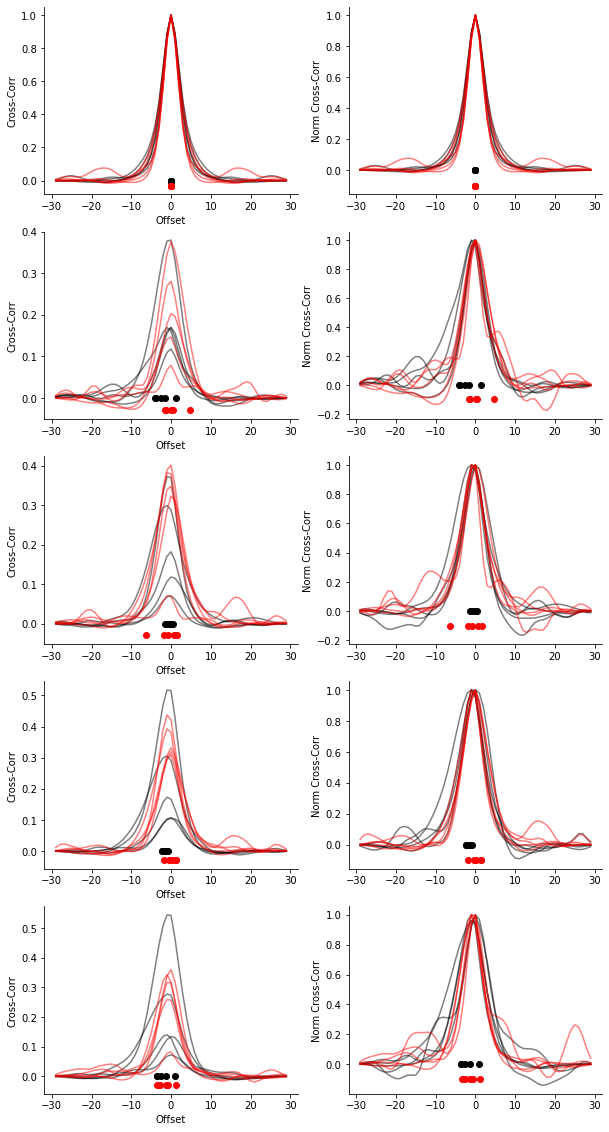

In [8]:
fig, ax = plt.subplots(5,2, figsize=[10,20])

x = np.arange(-29,30)
nov = [-1,1,-1,1,-1]


for mouse, _nov in zip(ctrl_mice,nov):
    lr = res['ctrl_res'][mouse][0]['trial_info']['LR']
    cc_nov = res['ctrl_res'][mouse][0]['cc_mat'][lr==_nov,:,:][:,lr==_nov,:]
    nov_com = cc_com(cc_nov)
    print(nov_com.shape)
    for trial in range(0,5):
        ax[trial,0].plot(x,cc_nov[trial,0,:], color = 'black',alpha = .5)
        ax[trial,1].plot(x,cc_nov[trial,0,:]/np.amax(cc_nov[0,trial,:]), color = 'black', alpha=.5)

        ax[trial,1].scatter(nov_com[trial,0],0,c='black', alpha = 1)
        ax[trial,0].scatter(nov_com[trial,0],0,c='black', alpha = 1)
        
        ax[trial,0].set_ylabel('Cross-Corr')
        ax[trial,0].set_xlabel('Offset')
        ax[trial,1].set_ylabel('Norm Cross-Corr')
        
        ax[trial,0].spines['top'].set_visible(False)
        ax[trial,0].spines['right'].set_visible(False)
        ax[trial,1].spines['top'].set_visible(False)
        ax[trial,1].spines['right'].set_visible(False)



for mouse, _nov in zip(ko_mice, nov):
    lr = res['ko_res'][mouse][0]['trial_info']['LR']
    cc_nov = res['ko_res'][mouse][0]['cc_mat'][lr==_nov,:,:][:,lr==_nov,:]
    nov_com = cc_com(cc_nov)
    print(nov_com.shape)
    for trial in range(0,5):
        ax[trial,0].plot(x,cc_nov[trial,0,:], color = 'red', alpha=.5)
        ax[trial,1].plot(x,cc_nov[trial,0,:]/np.amax(cc_nov[0,trial,:]), color = 'red',alpha=.5)
        ax[trial,1].scatter(nov_com[trial,0],-.1,c='red', alpha = 1)
        ax[trial,0].scatter(nov_com[trial,0],-.03,c='red', alpha = 1)
#         ax[trial,1].vlines(nov_com[0,trial],0,1,color='red', alpha = 1)


fig.savefig(os.path.join(figdir,"trial0ref_crosscorr.pdf"),format = 'pdf')

In [8]:
sess = u.load_single_day(ctrl_mice[0],0)
print(sess.novel_arm)

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
-1


IndexError: list index out of range

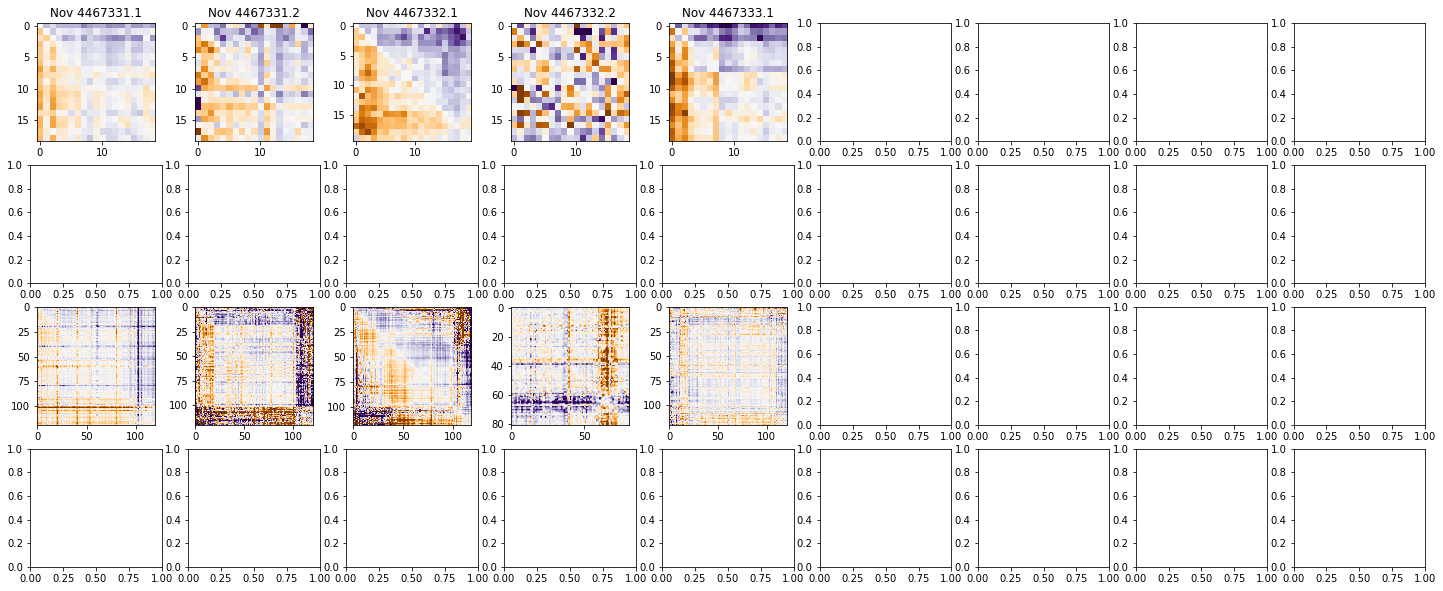

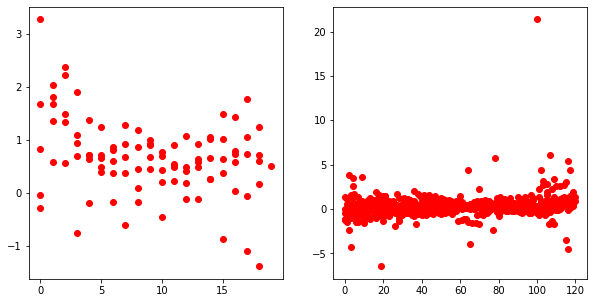

In [9]:
days_z = np.arange(6)/6. #sp.stats.zscore(np.arange(5))
df = pd.DataFrame({'mouse': [],
                       'day': [],
                       'dz': [],
                       'ko': [],
                       'ko_x_day': [],
                       'nov': [],
                       'nov_x_day': [],
                       'nov_x_ko': [],
                       'shift': [],
                       'speed': [],
                       'intercept': 1,
                       'ko_x_nov_x_day': []})

# df_fam = pd.DataFrame({'mouse': [],
#      'day': [],
#      'dz': [],
#      'ko': [],
#      'shift': [],
#      })

nov_arm = [-1, 1, -1, 1, -1]
color= ['red', 'black']
nov_shift_means = np.zeros([2,5,5])
nov_shift_avgmat = np.zeros([2,5,5,5,5])

fam_shift_means = np.zeros([2,5,5])
fam_shift_avgmat = np.zeros([2,5,5,20,20])

for day in range(5):
    fig_cc, ax_cc = plt.subplots(4,9,figsize=[25,10])
    fig_sh, ax_sh = plt.subplots(1,2, figsize = [10,5])
    
    for row, (mice, _res) in enumerate(zip([ctrl_mice, ko_mice], [res['ctrl_res'], res['ko_res']])):
        for m, mouse in enumerate(mice):
            cc_mat = _res[mouse][day]['cc_mat']
            lr, block_number, speed = _res[mouse][day]['trial_info']['LR'], _res[mouse][day]['trial_info']['block_number'], _res[mouse][day]['speed']

            nov_mat = cc_mat[lr==nov_arm[m],:,:][:,lr==nov_arm[m],:]
#             nov_com = cc_com(nov_mat)
            nov_com = cc_com(nov_mat[:,:,9:-9], inds = np.arange(-20,21))
            ax_cc[row,m].imshow(nov_com,vmin=-5, vmax=5, cmap='PuOr')
            ax_cc[row,m].set_title("Nov %s" % mouse)
            
            nov_shift = (nov_com*(np.tril(-1*np.ones(nov_com.shape),k=-1) + np.triu(np.ones(nov_com.shape), k=0))).mean(axis=0)
            ax_sh[0].scatter(np.arange(0,nov_shift.shape[0]),nov_shift, color=color[row])
            nov_shift_means[row,m, day] = np.nanmean(nov_shift[:5])
            
            nov_speed = speed[lr==nov_arm[m]]
#             df_nov = df_nov.append({'mouse': m + row*5, 'day': day, 'dz': days_z[day], 'ko': row, 'shift': np.nanmean(nov_shift[:5])}, ignore_index=True)
#             for trial in range(5):
            df = df.append({'mouse': m + row*5, 
                                    'day': day, 
                                    'dz': days_z[day], 
                                    'ko': row, 
                                    'ko_x_day': row*days_z[day], 
                                    'nov': 1,
                                    'nov_x_day': days_z[day],
                                    'nov_x_ko': row,
                                    'shift': np.nanmean(nov_shift[:5]),
                                    'speed': np.nanmean(nov_speed[:5]),
                                    'intercept': 1,
                                    'ko_x_nov_x_day': row*days_z[day],
                                   }, ignore_index=True)
            nov_shift_avgmat[row,day,m, :,:] = nov_com[:5,:5]
            
            
            fam_mat = cc_mat[lr==-1*nov_arm[m],:,:][:,lr==-1*nov_arm[m],:]
#             fam_com = cc_com(fam_mat)
            fam_com = cc_com(fam_mat[:,:,9:-9], inds = np.arange(-20,21))
            ax_cc[row+2,m].imshow(fam_com,vmin=-5, vmax=5, cmap='PuOr')
            
            fam_shift = (fam_com*(np.tril(-1*np.ones(fam_com.shape),k=-1) + np.triu(np.ones(fam_com.shape), k=0))).mean(axis=0)
            ax_sh[1].scatter(np.arange(0,fam_shift.shape[0]),fam_shift, color=color[row])
            fam_shift_means[row,m, day] = np.nanmean(fam_shift[:20])
            
            fam_speed = speed[lr==-1*nov_arm[m]]
            
#             for trial in range(5):
            df = df.append({'mouse': m + row*5, 
                                    'day': day, 
                                    'dz': days_z[day], 
                                    'ko': row, 
                                    'ko_x_day': row*days_z[day], 
                                    'nov': 0,
                                    'nov_x_day': 0,
                                    'nov_x_ko': 0,
                                    'shift': np.nanmean(fam_shift[:5]),
                                    'speed': np.nanmean(fam_speed[:5]),
                                    'intercept':1,
                                    'ko_x_nov_x_day': 0,
                                   }, ignore_index=True)
            fam_shift_avgmat[row,day,m, :,:] = fam_com[:20,:20]
    fig_cc.savefig(os.path.join(figdir, "day%d_pv_com_by_mouse.pdf" % day))

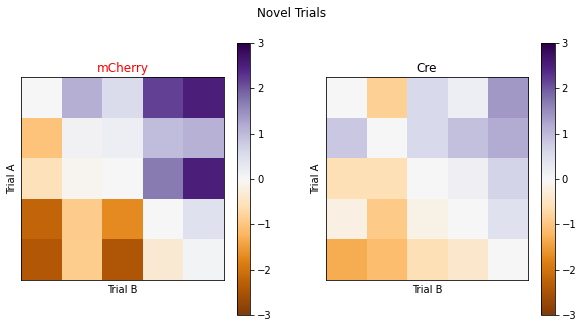

In [17]:
fig, ax = plt.subplots(1,2,figsize= [10,5])

h_l = ax[0].imshow(np.nanmean(nov_shift_avgmat[0,0,:,:,:],axis=0), vmin=-3, vmax=3, cmap = 'PuOr')
h_r = ax[1].imshow(np.nanmean(nov_shift_avgmat[1,0,:,:,:],axis=0), vmin=-3, vmax=3, cmap = 'PuOr')

plt.colorbar(h_l, ax= ax[0])
plt.colorbar(h_r, ax = ax[1])

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[0].set_ylabel('Trial A')
ax[0].set_xlabel('Trial B')

ax[1].set_ylabel('Trial A')
ax[1].set_xlabel('Trial B')

ax[0].set_title('mCherry', color = 'red')
ax[1].set_title('Cre', color = 'black')

fig.suptitle('Novel Trials')
fig.savefig(os.path.join(figdir, 'novel_trials_pv_crosscor_com.pdf'), format = 'pdf')

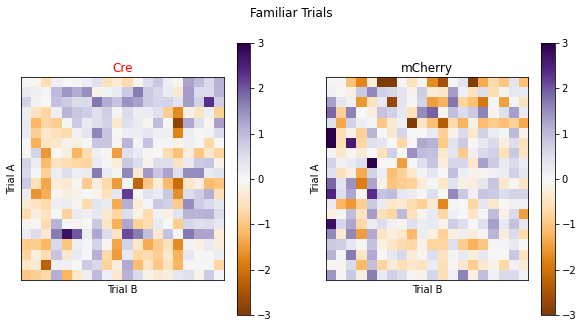

In [18]:
fig, ax = plt.subplots(1,2,figsize= [10,5])

h_l = ax[0].imshow(np.nanmean(fam_shift_avgmat[0,0,:,:,:],axis=0), vmin=-3, vmax=3, cmap = 'PuOr')
h_r = ax[1].imshow(np.nanmean(fam_shift_avgmat[1,0,:,:,:],axis=0), vmin=-3, vmax=3, cmap = 'PuOr')

plt.colorbar(h_l, ax= ax[0])
plt.colorbar(h_r, ax = ax[1])

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[0].set_ylabel('Trial A')
ax[0].set_xlabel('Trial B')

ax[1].set_ylabel('Trial A')
ax[1].set_xlabel('Trial B')

ax[0].set_title('Cre', color = 'red')
ax[1].set_title('mCherry', color = 'black')

fig.suptitle('Familiar Trials')
fig.savefig(os.path.join(figdir, 'fam_trials_pv_crosscor_com.pdf'), format = 'pdf')

In [22]:
df_nov = df[df['nov']==1]
lmm_res = MixedLM(df_nov['shift'], df_nov[['ko','dz', 'ko_x_day', 'speed', 'intercept']], df_nov['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: shift   
No. Observations: 50      Method:             REML    
No. Groups:       10      Scale:              0.1315  
Min. group size:  5       Log-Likelihood:     -21.8281
Max. group size:  5       Converged:          Yes     
Mean group size:  5.0                                 
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
ko          -0.524    0.205 -2.559 0.010 -0.925 -0.123
dz          -1.369    0.316 -4.332 0.000 -1.989 -0.750
ko_x_day     1.068    0.435  2.453 0.014  0.215  1.921
speed       -0.433    1.031 -0.421 0.674 -2.454  1.587
intercept    0.993    0.296  3.354 0.001  0.413  1.573
Group Var    0.008    0.055                           



/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [24]:
df_fam = df[df['nov']==0]
# lmm_res = MixedLM(df_fam['shift'], df_fam[['ko', 'dz', 'ko_x_day', 'intercept', 'nov', 'nov_x_ko', 'nov_x_day', 'ko_x_nov_x_day']], df_fam['mouse'])
# lmm_resf = lmm_res.fit()
# print(lmm_resf.summary())

In [25]:

anova_res = mixed_anova(data=df[df['nov']==1], dv='shift', between='ko', within='day', subject='mouse')
print(anova_res)

        Source        SS  DF1  DF2        MS         F     p-unc  p-GG-corr  \
0           ko  0.225072    1    8  0.225072  1.481791  0.258181        NaN   
1          day  2.381790    4   32  0.595448  5.047394  0.002869    0.03459   
2  Interaction  1.739244    4   32  0.434811  3.685736  0.014075        NaN   

        np2       eps sphericity   W-spher   p-spher  
0  0.156278       NaN        NaN       NaN       NaN  
1  0.386851  0.547439      False  0.067538  0.020637  
2  0.315405       NaN        NaN       NaN       NaN  


2.616633804152813 0.030811140919905992
0.8782919558795323 0.4053904564862696
-0.15583835347302089 0.880021003250076
-1.2232760286715272 0.2560328335736162
1.0679895896902811 0.3166897030427527


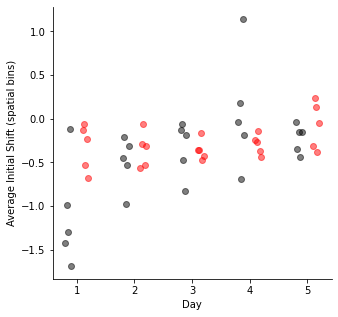

In [26]:
fig, ax = plt.subplots(figsize = [5,5])
for day in range(5):
    t,p = sp.stats.ttest_ind(nov_shift_means[0,:,day], nov_shift_means[1,:,day])
    print(t,p)
#     ax.scatter(10*day+np.linspace(0,.4, num=5), -fam_shift_means[0,:,day], color='black', s= 20)
    ax.scatter(10*day+np.linspace(1,2, num=5), -nov_shift_means[0,:,day], color='black', alpha = .5)#, s=10)
#     ax.scatter(10*day+np.linspace(3,3.4, num=5), -fam_shift_means[1,:,day], color='red', s= 20)
    ax.scatter(10*day+np.linspace(4,5, num=5), -nov_shift_means[1,:,day], color='red', alpha = .5) #, s = 10)
    
    
ax.set_ylabel('Average Initial Shift (spatial bins)')
ax.set_xlabel('Day')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(10*np.arange(5) + 3)
ax.set_xticklabels([1, 2, 3, 4, 5])

fig.savefig(os.path.join(figdir,"nov_initial_shifts.pdf"), format = 'pdf')

In [28]:
anova_res = mixed_anova(data=df[df['nov']==0], dv='shift', between='ko', within='day', subject='mouse')
print(anova_res)

        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0           ko  0.817717    1    8  0.817717  0.949976  0.358272  0.106143   
1          day  1.073764    4   32  0.268441  0.378950  0.821956  0.045226   
2  Interaction  1.702750    4   32  0.425688  0.600931  0.664685  0.069868   

        eps  
0       NaN  
1  0.641299  
2       NaN  


0.5560091999026889 0.5934100980369195
-0.4981016912614713 0.6318150347363525
-0.7289367762635228 0.48682912207257056
0.21304434809511788 0.836621120467077
-0.4957320656604801 0.6334133893469263


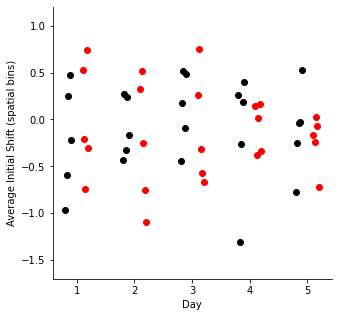

In [174]:
fig, ax = plt.subplots(figsize = [5,5])
for day in range(5):
    t,p = sp.stats.ttest_ind(fam_shift_means[0,:,day], fam_shift_means[1,:,day])
    print(t,p)
    ax.scatter(10*day+np.linspace(1,2, num=5), -fam_shift_means[0,:,day], color='black', alpha = 1)#, s=10)
#     ax.scatter(10*day+np.linspace(3,3.4, num=5), -fam_shift_means[1,:,day], color='red', s= 20)
    ax.scatter(10*day+np.linspace(4,5, num=5), -fam_shift_means[1,:,day], color='red', alpha = 1) #, s = 10
    
ax.set_ylabel('Average Initial Shift (spatial bins)')
ax.set_xlabel('Day')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(10*np.arange(5) + 3)
ax.set_xticklabels([1, 2, 3, 4, 5])
ax.set_ylim(-1.7,1.2)
    
fig.savefig(os.path.join(figdir,"fam_initial_shifts.pdf"), format = 'pdf')